In [1]:
import sys

In [2]:
sys.path.append('./../src/')

from manuscript import export, inout

sys.path.append(inout.gustav_path())
from gustav import ncbi

from gustav import nlm

In [3]:
user = 'general'
save = True

# Reference literature

In [4]:
ml = ncbi.pubmed('main', ['pubmed_id', 'year'])

## Find maximal year to consider

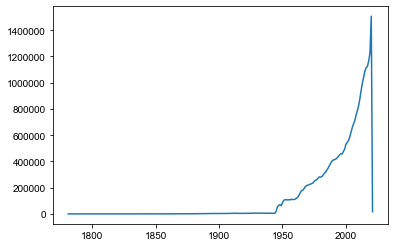

In [5]:
ml['year'].value_counts().sort_index().plot()

In [6]:
ml['year'].value_counts().sort_index().tail(20)

2002     558867
2003     584275
2004     620313
2005     656588
2006     685312
2007     710771
2008     751559
2009     784759
2010     823344
2011     876275
2012     940685
2013     996409
2014    1043878
2015    1088755
2016    1114134
2017    1124450
2018    1166587
2019    1226646
2020    1506074
2021      16770
Name: year, dtype: int64

In [7]:
ml = ml[ml['year']<=2020]

## Find reserach publications

In [8]:
forbidden_publication_types = [
        'D016454:Review',
        'D016422:Letter',
        'D016420:Comment',
        'D016421:Editorial',
        'D016456:Historical Article',
        'D016433:News',
        'D019215:Biography',
        'D016425:Published Erratum',
        'D054711:Introductory Journal Article',
        'D019477:Portrait',
        'D017203:Interview',
        'D016424:Overall',
        'D017065:Practice Guideline',
        'D059040:Video-Audio Media',
        'D018431:Newspaper Article',
        'D016417:Bibliography',
        'D016440:Retraction of Publication',
        'D016441:Retracted Publication',
        'D019531:Lecture',
        'D016435:Directory',
        'D016419:Classical Article',
        'D019484:Address',
        'D029282:Patient Education Handout',
        'D062210:Personal Narrative',
        'D020493:Autobiography',
        'D020485:Legislation',
        'D016221:Festschrift',
        'D016438:Duplicate Publication',
        'D057405:Webcast',
        'D064886:Dataset',
        'D016437:Dictionary',
        'D000075742:Expression of Concern',
        'D016453:Periodical Index',
        'D054710:Interactive Tutorial',
        'D016426:Scientific Integrity Review',
        'D020470:Collected Works',
        'D057405:Webcasts',
    ]

In [9]:
publication_types = ncbi.pubmed(
    'publication_types'
)

In [10]:
publication_types['forbidden'] = publication_types['publication_types'].isin(
    forbidden_publication_types
)
is_not_primary_research = publication_types.groupby('pubmed_id')['forbidden'].any()

## Define reference and export

### Any 

In [11]:
reference_publications = ml[ml['pubmed_id'].isin(
    is_not_primary_research[is_not_primary_research==False].index
)][['pubmed_id']].drop_duplicates()

In [12]:
if save:
    export.full_frame(user, 'references/literature.parquet', reference_publications)

### Subset: Human

In [13]:
mesh = ncbi.pubmed('mesh_terms')
human = mesh[mesh['mesh_terms']=='D006801:Humans']['pubmed_id']

reference_publications_humans = reference_publications[
    reference_publications['pubmed_id'].isin(human)
]

if save:
    export.full_frame(user, 'references/literature_human.parquet', reference_publications_humans)

# model organisms

In [14]:
def get_mesh_children(ui_of_interest):
    """
    Will identify the MeSH ui (e..g: D000001)
    that are childen of provided MeSH
    
    Input:
    ui    str e.g.: D000001
    
    Output
    uis   set with childen ui of input ui
    
    """

    ui = nlm.mesh('ui2mn')
    branch = ui[ui['ui'] == ui_of_interest]['mn'].values

    pattern = r'^' + r'|'.join(branch)
    
    
    return set(ui[ui['mn'].str.contains(pattern)]['ui'])

In [15]:
extra_species={
    'dmelanogaster': 'D004331:Drosophila melanogaster',
    'rat': 'D051381:Rats',
    'celegans': 'D017173:Caenorhabditis elegans',
    'scerevisiae': 'D012441:Saccharomyces cerevisiae',
    'drerio': 'D015027:Zebrafish',
    'mouse': 'D051379:Mice'
    
    
}

In [16]:
# c = mesh['mesh_terms'].value_counts()

In [17]:
mini_mesh = mesh[['mesh_terms']].drop_duplicates()
mini_mesh['mn'] = mini_mesh['mesh_terms'].str.extract('(.*):', expand=False)

In [18]:
for species in extra_species.keys():
    print(species)
    mns = extra_species[species].split(':')[0]
    
    if isinstance(mns, str):
        mns = [mns]
    
    meshs = set(mini_mesh[mini_mesh['mn'].isin(mns)]['mesh_terms'])

    in_species = mesh[mesh['mesh_terms'].isin(meshs)]['pubmed_id']

    reference_publications_in_species = reference_publications[
        reference_publications['pubmed_id'].isin(in_species)
    ]


    if save:
        export.full_frame(user, f'references/literature_{species}.parquet', reference_publications_in_species)
    

dmelanogaster
rat
celegans
scerevisiae
drerio
mouse
